In [3]:
import pandas as pd
import numpy as np
from hockey_rink import NHLRink, RinkImage
import matplotlib.pyplot as plt

In [4]:
#download dataframe
all_shots = pd.read_csv('season_shots.csv')

Function for visualizing shooting percentages

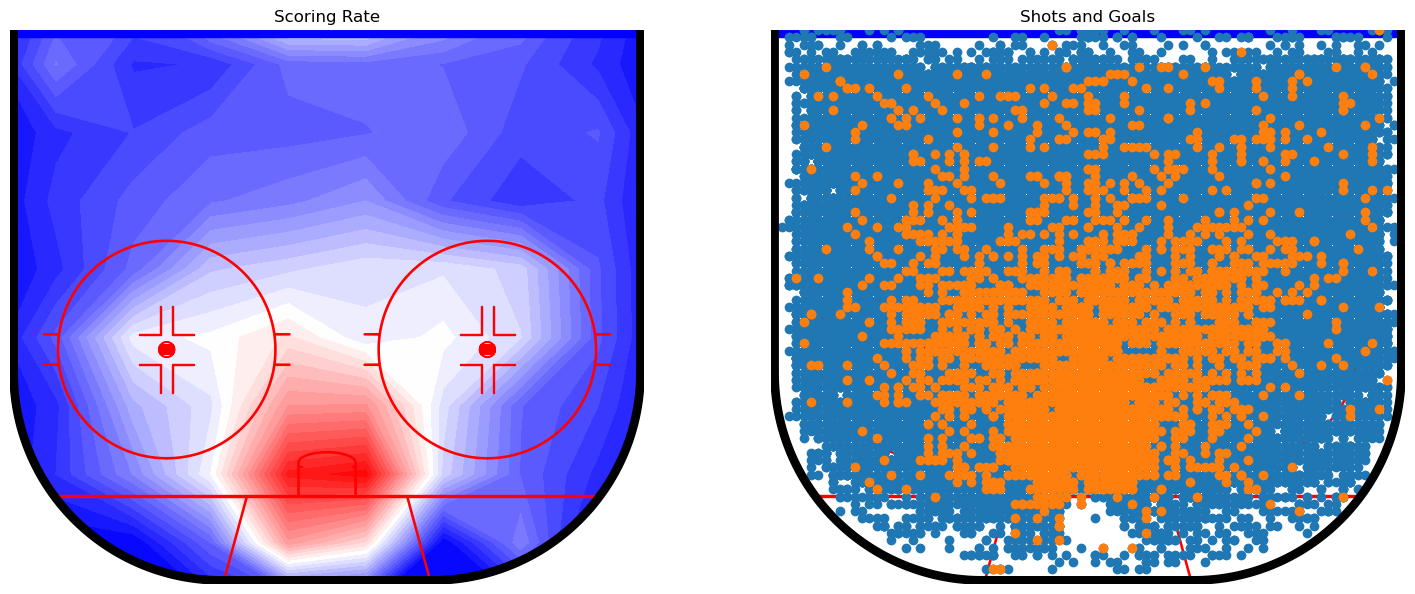

In [5]:
#create data frame with just the x, y, and goal marker.
def extract_locations(shot_data):
    return pd.DataFrame({'x':shot_data['x'],'y':shot_data['y'],'is_goal': (shot_data['event'] == 'Goal')})

#plot goals from the whole league, a team, or just one player
def shot_heat_map(shot_data,team=None):
    if team != None:
        shot_data = shot_data.loc[shot_data['team'] == team]
    goal_data = shot_data.loc[shot_data['event'] == 'Goal']   
        
    ozone_shots = extract_locations(shot_data)
    ozone_goals = extract_locations(goal_data)
    
    #sub plots
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))
    rink = NHLRink(rotation=270, net={"visible": False})
    
    #heat map
    rink.contourf(
    "x", "y", "is_goal", data=ozone_shots, 
    nbins=8, levels=30, plot_range="ozone", cmap="bwr",
    ax=axs[0], draw_kw={"display_range": "ozone"}
    )
    #shots
    rink.scatter("x", "y", data=ozone_shots, plot_range="ozone",ax=axs[1],draw_kw={"display_range": "ozone"})
    
    #goals
    rink.scatter("x", "y", data=ozone_goals, plot_range="ozone",ax=axs[1],draw_kw={"display_range": "ozone"})

    #titles
    axs[0].set_title('Scoring Rate')
    axs[1].set_title('Shots and Goals')
    
def plot_shots(shot_data,team=None):    
    if team != None:
        shot_data = shot_data.loc[shot_data['team'] == team]
    ozone_shots = pd.DataFrame({'x':shot_data['x'],'y':shot_data['y']})
    #create rink and plot offensive zone
    rink = NHLRink(rotation=270, net={"visible": False})
    rink.scatter("x", "y", data=ozone_shots, plot_range="ozone",draw_kw={"display_range": "ozone"})

shot_heat_map(all_shots)
#plot_shots(all_shots,'Washington Capitals')

Filter the shots into relevant data frames

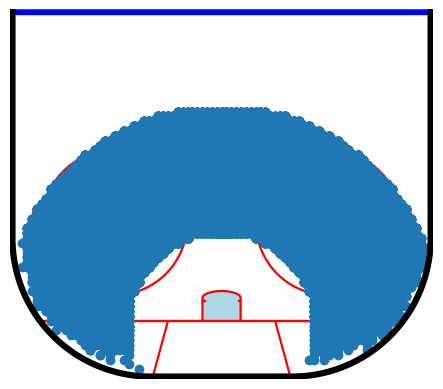

In [6]:
#change x and y to be mapped vertically:
all_shots['x'] = np.abs(all_shots['x'])
all_shots['y'] = (all_shots['y'] * np.sign(all_shots['x']))

#distance_column
all_shots['net_distance'] = np.sqrt( (all_shots['x'] - 90)**2 + all_shots['y']**2 )

#filter different shot types
reg_over_shots = all_shots.loc[(all_shots['period'] != 5) & (all_shots['empty_net'] != True)]

overtime_shots = all_shots.loc[(all_shots['period'] == 4) & (all_shots['empty_net'] != True)]
game_winners = all_shots.loc[(all_shots['period'] != 5) & (all_shots['game_winning_goal'] == True)]
close_shots = reg_over_shots.loc[reg_over_shots['net_distance'] < 19]
medium_shots = reg_over_shots.loc[(reg_over_shots['net_distance'] >= 19) & (reg_over_shots['net_distance'] < 45)]
far_shots = reg_over_shots.loc[reg_over_shots['net_distance'] > 45]


plot_shots(medium_shots)

export shots on goal for the classisfication probability model

In [7]:
shots_on_goal = reg_over_shots.loc[(reg_over_shots['event'] == 'Shot') | (reg_over_shots['event'] == 'Goal')]
shots_on_goal.to_csv('goal_probability_data.csv')

import shots on goal probabilities from the classification probability model

In [39]:
shot_probs = pd.read_csv('sog_with_probabilities.csv')
#get rid of blank columns
shot_probs = shot_probs.iloc[:,3:]
shot_probs.head(10)

,x,y,event,secondaryType,shooter,blocker,team,strength,period,game_winning_goal,empty_net,goalie,game_id,assist_1,assist_2,net_distance,shot probability
0,44.0,8.0,Shot,Wrist Shot,Timo Meier,None,San Jose Sharks,None,1,NaN,NaN,Juuse Saros,2022020001,NaN,NaN,46.690470,0.031839
1,33.0,8.0,Shot,Slap Shot,Mattias Ekholm,None,Nashville Predators,None,1,NaN,NaN,James Reimer,2022020001,NaN,NaN,57.558666,0.006729
2,74.0,-5.0,Goal,Wrist Shot,Kiefer Sherwood,None,Nashville Predators,Even,1,False,False,James Reimer,2022020001,Mattias Ekholm,Ryan McDonagh,16.763055,0.226578
3,81.0,15.0,Shot,Wrist Shot,Colton Sissons,None,Nashville Predators,None,1,NaN,NaN,James Reimer,2022020001,NaN,NaN,17.492856,0.174200
4,72.0,2.0,Shot,Tip-In,Steven Lorentz,None,San Jose Sharks,None,1,NaN,NaN,Juuse Saros,2022020001,NaN,NaN,18.110770,0.228953
5,40.0,22.0,Shot,Snap Shot,Dante Fabbro,None,Nashville Predators,None,1,NaN,NaN,James Reimer,2022020001,NaN,NaN,54.626001,0.008425
6,49.0,12.0,Shot,Wrist Shot,Oskar Lindblom,None,San Jose Sharks,None,1,NaN,NaN,Juuse Saros,2022020001,NaN,NaN,42.720019,0.047734
7,46.0,18.0,Shot,Slap Shot,Kevin Labanc,None,San Jose Sharks,None,1,NaN,NaN,Juuse Saros,2022020001,NaN,NaN,47.539457,0.024517
8,40.0,13.0,Shot,Wrist Shot,Matt Duchene,None,Nashville Predators,None,1,NaN,NaN,James Reimer,2022020001,NaN,NaN,51.662365,0.015615
9,71.0,21.0,Shot,Wrist Shot,Eeli Tolvanen,None,Nashville Predators,None,1,NaN,NaN,James Reimer,2022020001,NaN,NaN,28.319605,0.109661


Get sum of goal probabilities (expected goals) for each player

In [38]:
%%time
def f(x):
    return x['shot probability'].sum()
def get_expected_goals(shot_probs):
    xGoals = pd.DataFrame(shot_probs.groupby(['shooter']).apply(f))
    return xGoals
get_expected_goals(shot_probs).sort_values(0,ascending = False).head(10)


Wall time: 193 ms


,0
shooter,
Connor McDavid,54.538886
Brady Tkachuk,49.790531
Zach Hyman,49.611888
Matthew Tkachuk,48.519126
John Tavares,47.274942
Auston Matthews,45.704386
Jack Hughes,45.673669
David Pastrnak,42.248153
Timo Meier,41.658246


Function to get shooting percentages of all players

In [40]:
#function that takes a data set with only shots on goal and goals, with a column for probabilities
def shooting_percentage(shot_data,team=None):
    #can specify for just a team
    if team != None:
        shot_data = shot_data.loc[shot_data['team'] == team]
    #split the dataframe by sog and goals
    shots_on_goal = shot_data.loc[(shot_data['event'] == 'Shot') | (shot_data['event'] == 'Goal')]
    goals = shot_data.loc[shot_data['event'] == 'Goal']
    
    #get relevant stats
    season = pd.DataFrame({'total shots' : shot_data['shooter'].value_counts()})
    season['shots on goal'] = shot_data['shooter'].value_counts()
    season['goals'] = goals['shooter'].value_counts()
    season['total shooting %'] = season['goals'] / season['total shots']
    season['shots on goal %'] = season['goals'] / season['shots on goal']
    #if there is a column for shot probability (i.e. expected goals) add these columns
    if 'shot probability' in shot_data.columns:
        season['expected goals'] = get_expected_goals(shot_data)
        season['goals / expected'] = season['goals'] / season['expected goals']
        season['goals minus expected'] = season['goals'] - season['expected goals']
    #if the inputted data is already just sog, get rid of total columns
    if len(shots_on_goal) == len(shot_data):
        season = season.drop(columns=['total shooting %', 'total shots'])
    
    return season.sort_values('shots on goal %',ascending = False)

player_season_shots = shooting_percentage(shot_probs)
#get the top goals/expected
player_season_shots.loc[player_season_shots['shots on goal'] > 200].sort_values('goals / expected',ascending = False).head(10)

,shots on goal,goals,shots on goal %,expected goals,goals / expected,goals minus expected
Erik Karlsson,203,23.0,0.113300,11.211909,2.051390,11.788091
Dougie Hamilton,266,21.0,0.078947,11.871604,1.768927,9.128396
Mika Zibanejad,241,38.0,0.157676,24.978644,1.521300,13.021356
Leon Draisaitl,243,51.0,0.209877,34.242638,1.489371,16.757362
Claude Giroux,204,31.0,0.151961,22.201633,1.396294,8.798367
Tage Thompson,276,45.0,0.163043,32.394693,1.389116,12.605307
Brent Burns,239,14.0,0.058577,10.365835,1.350591,3.634165
Mikko Rantanen,290,48.0,0.165517,35.670920,1.345634,12.329080
Adrian Kempe,227,34.0,0.149780,25.361943,1.340591,8.638057
Clayton Keller,204,32.0,0.156863,24.591273,1.301275,7.408727


A look at Jared McCann shots: He has a very high sog% and goals/expected.

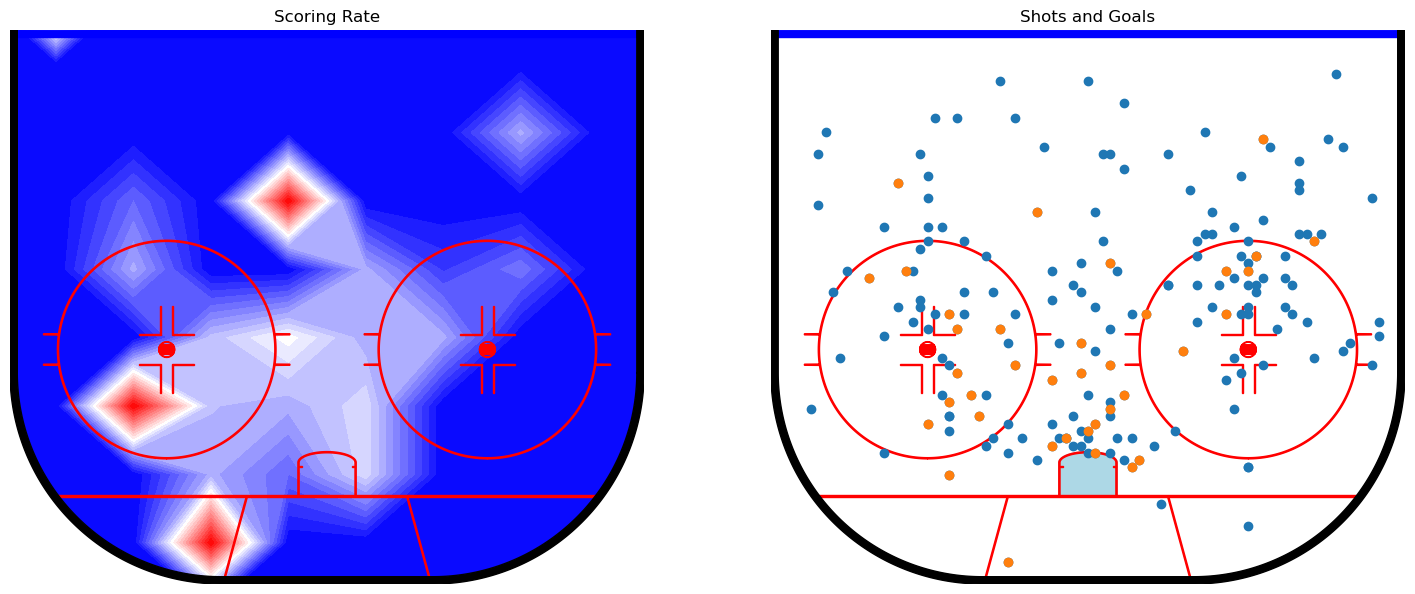

In [11]:
shot_heat_map(shot_probs.loc[shot_probs['shooter'] == 'Jared McCann'])

A look at more general season stats

In [36]:
player_season_stats = pd.read_csv('player_season_stats.csv')
player_season_stats = player_season_stats.iloc[:,1:].set_index('player')
player_season_stats.head(10)

,id,position,team,time on ice,assists,goals,points,pim,shots,games,hits,blocked shots,faceoff pct,plus minus
player,,,,,,,,,,,,,,
Brendan Smith,8474090,Defenseman,New Jersey Devils,912,5.0,0.0,5.0,63.0,58.0,59.0,96.0,75.0,0.00,2.0
Tomas Tatar,8475193,Left Wing,New Jersey Devils,1223,27.0,20.0,47.0,28.0,153.0,81.0,64.0,30.0,39.53,41.0
Erik Haula,8475287,Left Wing,New Jersey Devils,1312,27.0,12.0,39.0,47.0,160.0,79.0,92.0,54.0,54.43,11.0
Ondrej Palat,8476292,Left Wing,New Jersey Devils,761,15.0,8.0,23.0,6.0,79.0,49.0,70.0,44.0,0.00,5.0
Dougie Hamilton,8476462,Defenseman,New Jersey Devils,1762,52.0,21.0,73.0,48.0,272.0,81.0,63.0,86.0,0.00,24.0
Damon Severson,8476923,Defenseman,New Jersey Devils,1595,25.0,7.0,32.0,38.0,102.0,80.0,44.0,114.0,0.00,9.0
Miles Wood,8477425,Left Wing,New Jersey Devils,909,14.0,12.0,26.0,76.0,165.0,75.0,100.0,18.0,16.67,2.0
Ryan Graves,8477435,Defenseman,New Jersey Devils,1555,18.0,8.0,26.0,28.0,141.0,78.0,83.0,152.0,0.00,34.0
Curtis Lazar,8477508,Center,New Jersey Devils,574,2.0,3.0,5.0,14.0,55.0,48.0,136.0,51.0,52.31,-5.0


Combine the general stats with the specific shot stats

In [35]:
def per_60_mins(x,stat):
    x[f"{stat} per 60 mins"] = x[stat] / (x['time on ice'] / 60)
def player_complete_stats(player_season_stats, player_season_shots):
    player_season_shots = player_season_shots.rename(columns={'goals':'non shootout/emptynet goals'})
    complete = pd.merge(player_season_stats, player_season_shots, left_index=True, right_index=True)
    stats = ["assists","goals","points","pim","hits","blocked shots","shots on goal","expected goals"]
    for stat in stats:
        per_60_mins(complete,stat)
    return  complete
player_complete_stats = player_complete_stats(player_season_stats, player_season_shots)
player_complete_stats.head(10)

,id,position,team,time on ice,assists,goals,points,pim,shots,games,hits,blocked shots,faceoff pct,plus minus,shots on goal,non shootout/emptynet goals,shots on goal %,expected goals,goals / expected,goals minus expected,assists per 60 mins,goals per 60 mins,points per 60 mins,pim per 60 mins,hits per 60 mins,blocked shots per 60 mins,shots on goal per 60 mins,expected goals per 60 mins
A.J. Greer,8478421,Left Wing,Boston Bruins,543,7.0,5.0,12.0,109.0,64.0,60.0,101.0,25.0,66.67,8.0,60,4.0,0.066667,8.886497,0.450121,-4.886497,0.773481,0.552486,1.325967,12.044199,11.160221,2.762431,6.629834,0.981933
Aaron Ekblad,8477932,Defenseman,Florida Panthers,1636,24.0,14.0,38.0,68.0,212.0,70.0,74.0,80.0,0.00,-12.0,205,12.0,0.058537,12.174717,0.985649,-0.174717,0.880196,0.513447,1.393643,2.493888,2.713936,2.933985,7.518337,0.446506
Adam Boqvist,8480871,Defenseman,Columbus Blue Jackets,827,17.0,5.0,22.0,8.0,67.0,44.0,23.0,45.0,0.00,-14.0,67,5.0,0.074627,4.432566,1.128015,0.567434,1.233374,0.362757,1.596131,0.580411,1.668682,3.264813,4.860943,0.321589
Adam Erne,8477454,Left Wing,Detroit Red Wings,803,10.0,8.0,18.0,21.0,53.0,60.0,160.0,53.0,46.15,-11.0,50,7.0,0.140000,8.148755,0.859027,-1.148755,0.747198,0.597758,1.344956,1.569116,11.955168,3.960149,3.735990,0.608873
Adam Fox,8479323,Defenseman,New York Rangers,1976,59.0,12.0,71.0,34.0,158.0,81.0,25.0,123.0,0.00,28.0,157,11.0,0.070064,12.427097,0.885162,-1.427097,1.791498,0.364372,2.155870,1.032389,0.759109,3.734818,4.767206,0.377341
Adam Henrique,8474641,Center,Anaheim Ducks,1109,15.0,22.0,37.0,22.0,130.0,61.0,28.0,45.0,51.06,-8.0,120,17.0,0.141667,19.288524,0.881353,-2.288524,0.811542,1.190261,2.001803,1.190261,1.514878,2.434626,6.492335,1.043563
Adam Larsson,8476457,Defenseman,Seattle Kraken,1919,25.0,8.0,33.0,45.0,141.0,81.0,220.0,173.0,0.00,28.0,137,6.0,0.043796,5.480116,1.094867,0.519884,0.781657,0.250130,1.031787,1.406983,6.878583,5.409067,4.283481,0.171343
Adam Lowry,8476392,Center,Winnipeg Jets,1265,23.0,13.0,36.0,48.0,124.0,81.0,161.0,46.0,50.43,6.0,116,10.0,0.086207,18.352392,0.544888,-8.352392,1.090909,0.616601,1.707510,2.276680,7.636364,2.181818,5.501976,0.870469
Adam Pelech,8476917,Defenseman,New York Islanders,1297,14.0,6.0,20.0,36.0,94.0,60.0,75.0,109.0,0.00,15.0,87,5.0,0.057471,3.260773,1.533379,1.739227,0.647648,0.277564,0.925212,1.665382,3.469545,5.042406,4.024672,0.150845
Adam Ruzicka,8480008,Center,Calgary Flames,509,14.0,6.0,20.0,8.0,64.0,44.0,28.0,8.0,47.70,-1.0,64,6.0,0.093750,7.146467,0.839576,-1.146467,1.650295,0.707269,2.357564,0.943026,3.300589,0.943026,7.544204,0.842413


Function to display all the leaders of every stat, for a specific data frame

In [14]:
pd.set_option('display.max_columns', None)

def get_top(amount,stat,df):
    new = df.sort_values(stat,ascending=False).head(amount)
    new[f"top {amount} players: {stat}"] = new.index
    new = new[[f"top {amount} players: {stat}",stat]]
    return new.reset_index(drop = True)

def group_analysis(player_complete_stats,shot_data,top_amount):
    
    stats = ['assists', 'goals', 'points',
       'pim', 'shots', 'games', 'hits', 'blocked shots', 'faceoff pct',
       'plus minus', 'shots on goal', 'non shootout/emptynet goals', 'shots on goal %',
       'expected goals', 'goals / expected', 'goals minus expected',
       'assists per 60 mins', 'goals per 60 mins', 'points per 60 mins',
       'pim per 60 mins', 'hits per 60 mins',
       'blocked shots per 60 mins', 'shots on goal per 60 mins',
       'expected goals per 60 mins']
    stat_df = get_top(top_amount,'time on ice',player_complete_stats)#pd.DataFrame()
    
    for stat in stats:
        stat_df = stat_df.join(get_top(top_amount,stat,player_complete_stats))
    
    return stat_df

group_analysis(player_complete_stats.loc[player_complete_stats['time on ice']>500],reg_over_shots,10)

,top 10 players: time on ice,time on ice,top 10 players: assists,assists,top 10 players: goals,goals,top 10 players: points,points,top 10 players: pim,pim,top 10 players: shots,shots,top 10 players: games,games,top 10 players: hits,hits,top 10 players: blocked shots,blocked shots,top 10 players: faceoff pct,faceoff pct,top 10 players: plus minus,plus minus,top 10 players: shots on goal,shots on goal,top 10 players: non shootout/emptynet goals,non shootout/emptynet goals,top 10 players: shots on goal %,shots on goal %,top 10 players: expected goals,expected goals,top 10 players: goals / expected,goals / expected,top 10 players: goals minus expected,goals minus expected,top 10 players: assists per 60 mins,assists per 60 mins,top 10 players: goals per 60 mins,goals per 60 mins,top 10 players: points per 60 mins,points per 60 mins,top 10 players: pim per 60 mins,pim per 60 mins,top 10 players: hits per 60 mins,hits per 60 mins,top 10 players: blocked shots per 60 mins,blocked shots per 60 mins,top 10 players: shots on goal per 60 mins,shots on goal per 60 mins,top 10 players: expected goals per 60 mins,expected goals per 60 mins
0,Drew Doughty,2101,Connor McDavid,88.0,Connor McDavid,64.0,Connor McDavid,152.0,Pat Maroon,150.0,David Pastrnak,404.0,Garnet Hathaway,83.0,Luke Schenn,316.0,Alec Martinez,242.0,Alex Pietrangelo,100.00,Hampus Lindholm,50.0,David Pastrnak,375,Connor McDavid,58.0,Andrei Kuzmenko,0.264286,Connor McDavid,54.538886,Michael Stone,5.491446,Jared McCann,19.302116,Nikita Kucherov,3.011016,David Pastrnak,2.269861,Connor McDavid,5.010989,A.J. Greer,12.044199,Michael Pezzetta,24.618117,Alec Martinez,9.986245,Sebastian Aho,15.128205,John Tavares,2.008850
1,Erik Karlsson,2056,Nikita Kucherov,82.0,David Pastrnak,60.0,Leon Draisaitl,125.0,Nicolas Deslauriers,136.0,Nathan MacKinnon,357.0,Tyson Barrie,83.0,Radko Gudas,302.0,Brayden McNabb,195.0,Nikita Kucherov,100.00,Matt Grzelcyk,47.0,Nathan MacKinnon,337,David Pastrnak,53.0,Brayden Point,0.217195,Brady Tkachuk,49.790531,Alexander Edler,3.404222,Leon Draisaitl,16.757362,Connor McDavid,2.901099,Connor McDavid,2.109890,Leon Draisaitl,4.347826,Pat Maroon,11.029412,Nicolas Deslauriers,22.735257,Nick Seeler,8.579235,David Pastrnak,14.186633,Brady Tkachuk,1.981056
2,Adam Fox,1976,Erik Karlsson,75.0,Mikko Rantanen,54.0,Nikita Kucherov,112.0,Brady Tkachuk,126.0,Connor McDavid,347.0,Lars Eller,82.0,Nicolas Deslauriers,302.0,Andrew Peeke,194.0,Brent Burns,100.00,Brandon Carlo,44.0,Brady Tkachuk,331,Leon Draisaitl,51.0,Pavel Buchnevich,0.210084,Zach Hyman,49.611888,Kevin Bahl,3.333515,Mika Zibanejad,13.021356,Nathan MacKinnon,2.649351,Tage Thompson,1.924686,Jason Robertson,4.217507,Liam O'Brien,10.891720,Keegan Kolesar,19.856631,Joel Edmundson,7.701648,Brady Tkachuk,13.169761,Zach Hyman,1.887580
3,Quinn Hughes,1975,Leon Draisaitl,74.0,Leon Draisaitl,51.0,David Pastrnak,111.0,Austin Watson,123.0,Brady Tkachuk,341.0,Dillon Dube,81.0,Jack McBain,299.0,Jacob Trouba,190.0,Zach Bogosian,100.00,Tomas Tatar,41.0,Connor McDavid,330,Mikko Rantanen,48.0,Leon Draisaitl,0.209877,Matthew Tkachuk,48.519126,Calle Rosen,3.037283,Tage Thompson,12.605307,Leon Draisaitl,2.573913,Jared McCann,1.885310,David Pastrnak,4.199243,Mark Kastelic,10.812721,Matt Martin,19.685393,David Savard,7.608069,Nathan MacKinnon,13.129870,Auston Matthews,1.852881
4,Miro Heiskanen,1966,Mitchell Marner,69.0,Brayden Point,49.0,Matthew Tkachuk,108.0,Liam O'Brien,114.0,Jack Hughes,331.0,Ryan Nugent-Hopkins,81.0,Matt Martin,292.0,Moritz Seider,189.0,Troy Terry,100.00,Joe Pavelski,41.0,Jack Hughes,326,Brayden Point,48.0,Nic Dowd,0.209677,John Tavares,47.274942,Arber Xhekaj,3.029749,Andrei Kuzmenko,12.519411,Matthew Tkachuk,2.559598,Cole Caufield,1.879518,Nathan MacKinnon,4.168831,Nicolas Deslauriers,10.238394,Cal Clutterbuck,19.587629,Brayden McNabb,7.280647,Timo Meier,12.851406,Sebastian Aho,1.828225
5,Cam Fowler,1961,Nathan MacKinnon,68.0,Tage Thompson,46.0,Nathan MacKinnon,107.0,Matthew Tkachuk,111.0,Auston Matthews,324.0,Sam Re

Get a thorough analysis of a player

id                                     8478402
position                                Center
team                           Edmonton Oilers
time on ice                               1820
assists                                   88.0
goals                                     64.0
points                                   152.0
pim                                       36.0
shots                                    347.0
games                                     81.0
hits                                      89.0
blocked shots                             39.0
faceoff pct                              51.84
plus minus                                22.0
shots on goal                              330
non shootout/emptynet goals               58.0
shots on goal %                       0.175758
expected goals                       54.538886
goals / expected                      1.063461
goals minus expected                  3.461114
assists per 60 mins                   2.901099
goals per 60 

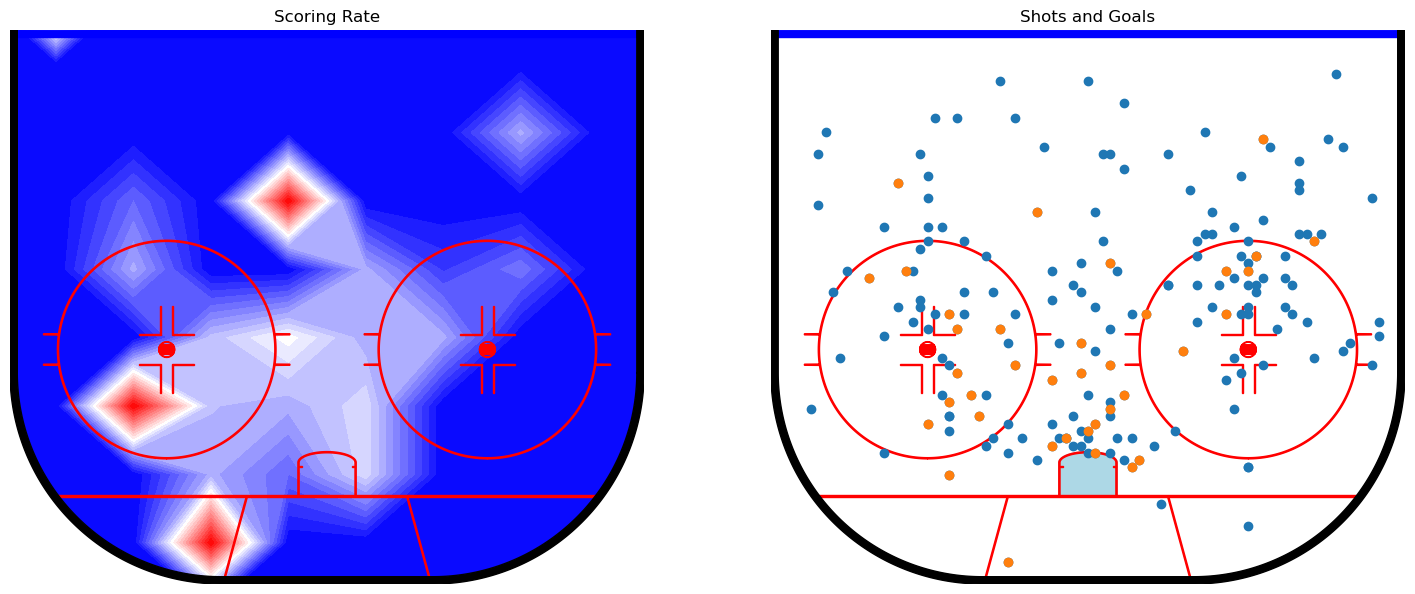

In [441]:
def player_analysis(player,player_complete_stats,shot_probs):
    shot_heat_map(shot_probs.loc[shot_probs['shooter'] == player])
    return player_complete_stats.loc[player]

get_player_stats("Connor McDavid",player_complete_stats,shot_probs)

Get a thorough analysis of a team

Slap Shots
                   shots on goal  goals  shots on goal %  expected goals  \
Mitchell Marner               15    4.0         0.266667        0.859023   
Calle Jarnkrok                12    2.0         0.166667        1.465979   
William Nylander              27    2.0         0.074074        1.388335   
Michael Bunting                6    1.0         0.166667        0.456367   
Alexander Kerfoot              7    1.0         0.142857        0.561029   
Conor Timmins                  8    1.0         0.125000        0.173317   
Timothy Liljegren             23    1.0         0.043478        0.574447   
Auston Matthews               40    1.0         0.025000        2.314575   

                   goals / expected  goals minus expected  
Mitchell Marner            4.656453              3.140977  
Calle Jarnkrok             1.364276              0.534021  
William Nylander           1.440574              0.611665  
Michael Bunting            2.191221              0.543633  
Alex

,top 5 players: time on ice,time on ice,top 5 players: assists,assists,top 5 players: goals,goals,top 5 players: points,points,top 5 players: pim,pim,top 5 players: shots,shots,top 5 players: games,games,top 5 players: hits,hits,top 5 players: blocked shots,blocked shots,top 5 players: faceoff pct,faceoff pct,top 5 players: plus minus,plus minus,top 5 players: shots on goal,shots on goal,top 5 players: non shootout/emptynet goals,non shootout/emptynet goals,top 5 players: shots on goal %,shots on goal %,top 5 players: expected goals,expected goals,top 5 players: goals / expected,goals / expected,top 5 players: goals minus expected,goals minus expected,top 5 players: assists per 60 mins,assists per 60 mins,top 5 players: goals per 60 mins,goals per 60 mins,top 5 players: points per 60 mins,points per 60 mins,top 5 players: pim per 60 mins,pim per 60 mins,top 5 players: hits per 60 mins,hits per 60 mins,top 5 players: blocked shots per 60 mins,blocked shots per 60 mins,top 5 players: shots on goal per 60 mins,shots on goal per 60 mins,top 5 players: expected goals per 60 mins,expected goals per 60 mins
0,Mitchell Marner,1678,Mitchell Marner,69.0,Auston Matthews,40.0,Mitchell Marner,99.0,Michael Bunting,103.0,Auston Matthews,324.0,Alexander Kerfoot,81.0,Luke Schenn,316.0,Jake McCabe,149.0,John Tavares,58.31,Auston Matthews,31.0,Auston Matthews,315,Auston Matthews,37.0,Calle Jarnkrok,0.182692,John Tavares,47.274942,Luke Schenn,1.890249,Mitchell Marner,5.178607,Mitchell Marner,2.467223,Auston Matthews,1.621622,Mitchell Marner,3.539928,Michael Bunting,4.835681,Luke Schenn,16.823425,Jake McCabe,6.127485,Auston Matthews,12.770270,John Tavares,2.008850
1,Justin Holl,1598,William Nylander,47.0,William Nylander,39.0,William Nylander,86.0,Luke Schenn,82.0,William Nylander,287.0,David Kampf,81.0,Noel Acciari,243.0,Mark Giordano,147.0,Ryan O'Reilly,55.75,Mark Giordano,27.0,William Nylander,267,William Nylander,35.0,Ryan O'Reilly,0.144330,Auston Matthews,45.704386,Timothy Liljegren,1.555175,Calle Jarnkrok,4.476642,William Nylander,1.875000,William Nylander,1.555851,Auston Matthews,3.445946,Luke Schenn,4.365572,Noel Acciari,13.400735,Mark Giordano,5.967524,John Tavares,11.260623,Auston Matthews,1.852881
2,William Nylander,1504,Auston Matthews,45.0,John Tavares,36.0,Auston Matthews,85.0,Jake McCabe,56.0,John Tavares,277.0,William Nylander,81.0,Jake McCabe,163.0,Justin Holl,137.0,Noel Acciari,53.71,Timothy Liljegren,22.0,John Tavares,265,John Tavares,32.0,Mitchell Marner,0.139037,William Nylander,36.507757,Calle Jarnkrok,1.308237,Timothy Liljegren,1.784928,John Tavares,1.869688,John Tavares,1.529745,William Nylander,3.430851,Jake McCabe,2.302947,Zach Aston-Reese,11.724970,TJ Brodie,5.454545,William Nylander,10.651596,William Nylander,1.456426
3,Auston Matthews,1480,John Tavares,44.0,Mitchell Marner,30.0,John Tavares,80.0,Mark Giordano,53.0,Mitchell Marner,195.0,Michael Bunting,81.0,Zach Aston-Reese,162.0,TJ Brodie,110.0,Auston Matthews,52.46,Michael Bunting,21.0,Mitchell Marner,187,Mitchell Marner,26.0,William Nylander,0.131086,Michael Bunting,26.416328,Mitchell Marner,1.248716,Luke Schenn,1.412907,Auston Matthews,1.824324,Calle Jarnkrok,1.157184,John Tavares,3.399433,Sam Lafferty,2.172211,Sam Lafferty,7.338552,Luke Schenn,5.164153,Michael Bunting,7.464789,Michael Bunting,1.240203
4,Mark Giordano,1478,Morgan Rielly,37.0,Michael Bunting,23.0,Michael Bunting,49.0,Justin Holl,39.0,Michael Bunting,171.0,John Tavares,80.0,Justin Holl,147.0,Luke Schenn,97.0,David Kampf,51.37,Mitchell Marner,18.0,Michael Bunting,159,Michael Bunting,20.0,Michael Bunting,0.125786,Mitchell Marner,20.821393,Erik Gustafsson,1.115910,Erik Gustafsson,0.727090,Morgan Rielly,1.594828,Michael Bunting,1.079812,Michael Bunting,2.300469,Mark Giordano,2.151556,Jake McCabe,6.703221,Justin Holl,5.143930,Mitchell Marner,6.686532,Ryan O'Reilly,0.940030


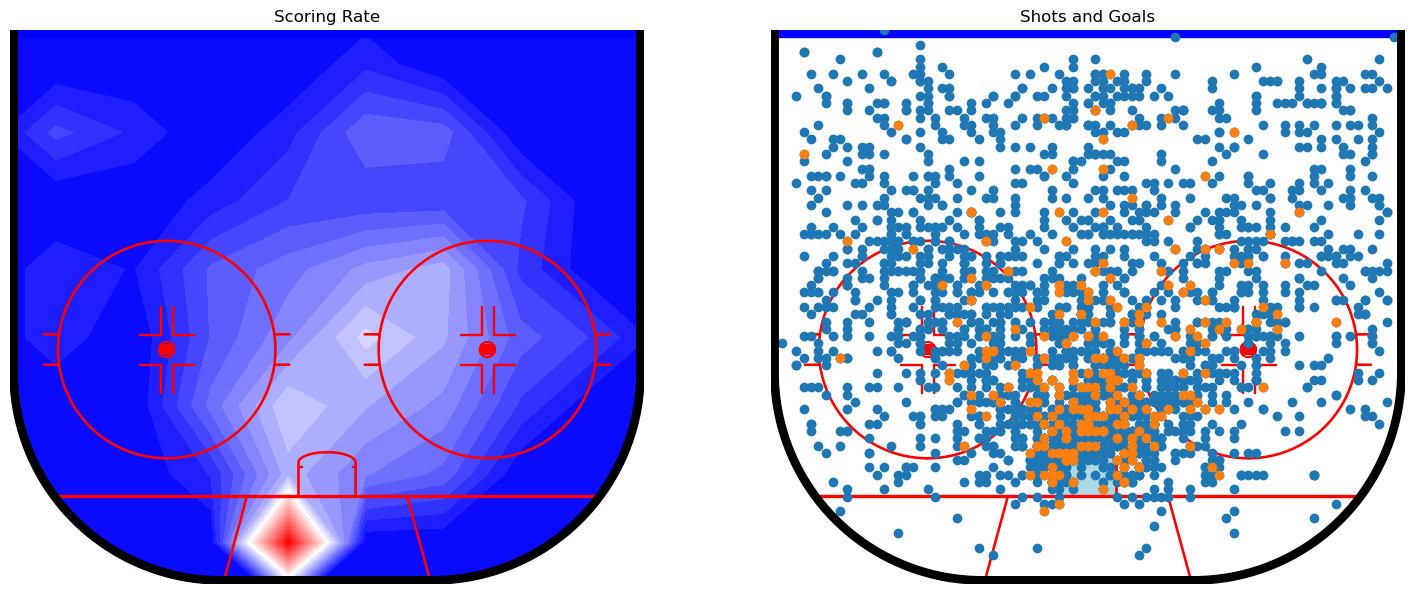

In [56]:
#different types of shot/goal scenerios to display
def shot_scenarios(shot_probs,team):
    return {'Slap Shots': shooting_percentage(shot_probs.loc[(shot_probs['secondaryType']=='Slap Shot') & (shot_probs['team'] == team)]),
                'Wrist Shots': shooting_percentage(shot_probs.loc[(shot_probs['secondaryType']=='Slap Shot') & (shot_probs['team'] == team)]),
                'Close Shots': shooting_percentage(shot_probs.loc[(shot_probs['net_distance'] < 19) & (shot_probs['team'] == team)]),
                'Medium Shots': shooting_percentage(shot_probs.loc[(shot_probs['net_distance'] >= 19) & (shot_probs['net_distance'] < 45) & (shot_probs['team'] == team)]),
                'Far Shots': shooting_percentage(shot_probs.loc[(shot_probs['net_distance'] > 45) & (shot_probs['team'] == team)]),
                'Game Winners': shooting_percentage(shot_probs.loc[(shot_probs['game_winning_goal']==True) & (shot_probs['team'] == team)])['goals']}
#display different shot scenarios, as well as the full team analysis (top players for each stat)
def team_analysis(team,player_complete_stats,shot_probs):
    shot_heat_map(shot_probs.loc[shot_probs['team'] == team])
    
    shotTypes = shot_scenarios(shot_probs,team)
    for name,df in shotTypes.items():
        print(name)
        if name == 'Game Winners': print(df)
        else: print(df.dropna().sort_values('goals',ascending=False))
        print("")
    return group_analysis(player_complete_stats.loc[ (player_complete_stats['time on ice']>400) & (player_complete_stats['team']==team) ],shot_probs,5)


team_analysis("Toronto Maple Leafs",player_complete_stats,shot_probs)

Slap Shots
                       shots on goal  goals  shots on goal %  expected goals  \
Steven Stamkos                    81   13.0         0.160494        5.862709   
Nikita Kucherov                   50    8.0         0.160000        3.100377   
Mikhail Sergachev                 30    4.0         0.133333        0.364986   
Victor Hedman                     45    3.0         0.066667        0.858274   
Nick Perbix                       21    2.0         0.095238        0.547953   
Ross Colton                       22    2.0         0.090909        1.626503   
Vladislav Namestnikov              3    1.0         0.333333        0.387644   
Nicholas Paul                      3    1.0         0.333333        0.154862   
Brandon Hagel                      5    1.0         0.200000        0.375664   
Anthony Cirelli                    6    1.0         0.166667        0.803907   
Corey Perry                        9    1.0         0.111111        0.782748   
Zach Bogosian                

,top 5 players: time on ice,time on ice,top 5 players: assists,assists,top 5 players: goals,goals,top 5 players: points,points,top 5 players: pim,pim,top 5 players: shots,shots,top 5 players: games,games,top 5 players: hits,hits,top 5 players: blocked shots,blocked shots,top 5 players: faceoff pct,faceoff pct,top 5 players: plus minus,plus minus,top 5 players: shots on goal,shots on goal,top 5 players: non shootout/emptynet goals,non shootout/emptynet goals,top 5 players: shots on goal %,shots on goal %,top 5 players: expected goals,expected goals,top 5 players: goals / expected,goals / expected,top 5 players: goals minus expected,goals minus expected,top 5 players: assists per 60 mins,assists per 60 mins,top 5 players: goals per 60 mins,goals per 60 mins,top 5 players: points per 60 mins,points per 60 mins,top 5 players: pim per 60 mins,pim per 60 mins,top 5 players: hits per 60 mins,hits per 60 mins,top 5 players: blocked shots per 60 mins,blocked shots per 60 mins,top 5 players: shots on goal per 60 mins,shots on goal per 60 mins,top 5 players: expected goals per 60 mins,expected goals per 60 mins
0,Mikhail Sergachev,1859,Nikita Kucherov,82.0,Brayden Point,49.0,Nikita Kucherov,112.0,Pat Maroon,150.0,Nikita Kucherov,268.0,Alex Killorn,81.0,Tanner Jeannot,290.0,Mikhail Sergachev,148.0,Zach Bogosian,100.00,Brandon Hagel,21.0,Nikita Kucherov,253,Brayden Point,48.0,Brayden Point,0.217195,Brayden Point,41.532289,Mikhail Sergachev,1.675600,Brayden Point,6.467711,Nikita Kucherov,3.011016,Brayden Point,1.844417,Nikita Kucherov,4.112607,Pat Maroon,11.029412,Tanner Jeannot,16.066482,Ian Cole,4.869215,Michael Eyssimont,10.816641,Brayden Point,1.563323
1,Victor Hedman,1802,Mikhail Sergachev,52.0,Steven Stamkos,34.0,Brayden Point,92.0,Tanner Jeannot,107.0,Steven Stamkos,238.0,Nikita Kucherov,81.0,Erik Cernak,209.0,Victor Hedman,136.0,Nikita Kucherov,100.00,Alex Killorn,16.0,Steven Stamkos,231,Steven Stamkos,32.0,Alex Killorn,0.171642,Steven Stamkos,29.286073,Brayden Point,1.155727,Mikhail Sergachev,3.628789,Steven Stamkos,1.969796,Steven Stamkos,1.339462,Brayden Point,3.462986,Corey Perry,6.148867,Pat Maroon,12.573529,Mikhail Sergachev,4.776762,Nikita Kucherov,9.290086,Michael Eyssimont,1.435501
2,Nikita Kucherov,1634,Steven Stamkos,50.0,Nikita Kucherov,30.0,Steven Stamkos,84.0,Corey Perry,95.0,Brayden Point,230.0,Brayden Point,81.0,Ross Colton,186.0,Ian Cole,121.0,Ross Colton,55.85,Anthony Cirelli,12.0,Brayden Point,221,Nikita Kucherov,27.0,Brandon Hagel,0.140244,Nikita Kucherov,26.788896,Alex Killorn,1.108604,Steven Stamkos,2.713927,Mikhail Sergachev,1.678322,Brandon Hagel,1.163880,Steven Stamkos,3.309258,Tanner Jeannot,5.927978,Ross Colton,11.318458,Victor Hedman,4.528302,Steven Stamkos,9.100460,Ross Colton,1.252078
3,Brayden Point,1594,Brayden Point,43.0,Brandon Hagel,29.0,Alex Killorn,62.0,Ian Cole,61.0,Victor Hedman,185.0,Brandon Hagel,80.0,Pat Maroon,171.0,Erik Cernak,100.0,Nicholas Paul,53.63,Ian Cole,11.0,Victor Hedman,177,Alex Killorn,23.0,Steven Stamkos,0.138528,Brandon Hagel,26.440835,Steven Stamkos,1.092670,Alex Killorn,2.253178,Brayden Point,1.618570,Alex Killorn,1.121495,Alex Killorn,2.674335,Michael Eyssimont,5.639445,Zach Bogosian,10.134529,Erik Cernak,4.457652,Ross Colton,9.006085,Corey Perry,1.162912
4,Steven Stamkos,1523,Victor Hedman,40.0,Alex Killorn,26.0,Mikhail Sergachev,62.0,Michael Eyssimont,61.0,Brandon Hagel,175.0,Corey Perry,80.0,Mikhail Sergachev,125.0,Nick Perbix,64.0,Steven Stamkos,53.54,Mikhail Sergachev,11.0,Brandon Hagel,164,Brandon Hagel,23.0,Nicholas Paul,0.119266,Alex Killorn,20.746822,Nikita Kucherov,1.007880,Nikita Kucherov,0.211104,Alex Killorn,1.552840,Nikita Kucherov,1.101591,Brandon Hagel,2.488294,Zach Bogosian,3.766816,Michael Eyssimont,9.799692,Zach Bogosian,4.394619,Brayden Point,8.318695,Steven Stamkos,1.153752


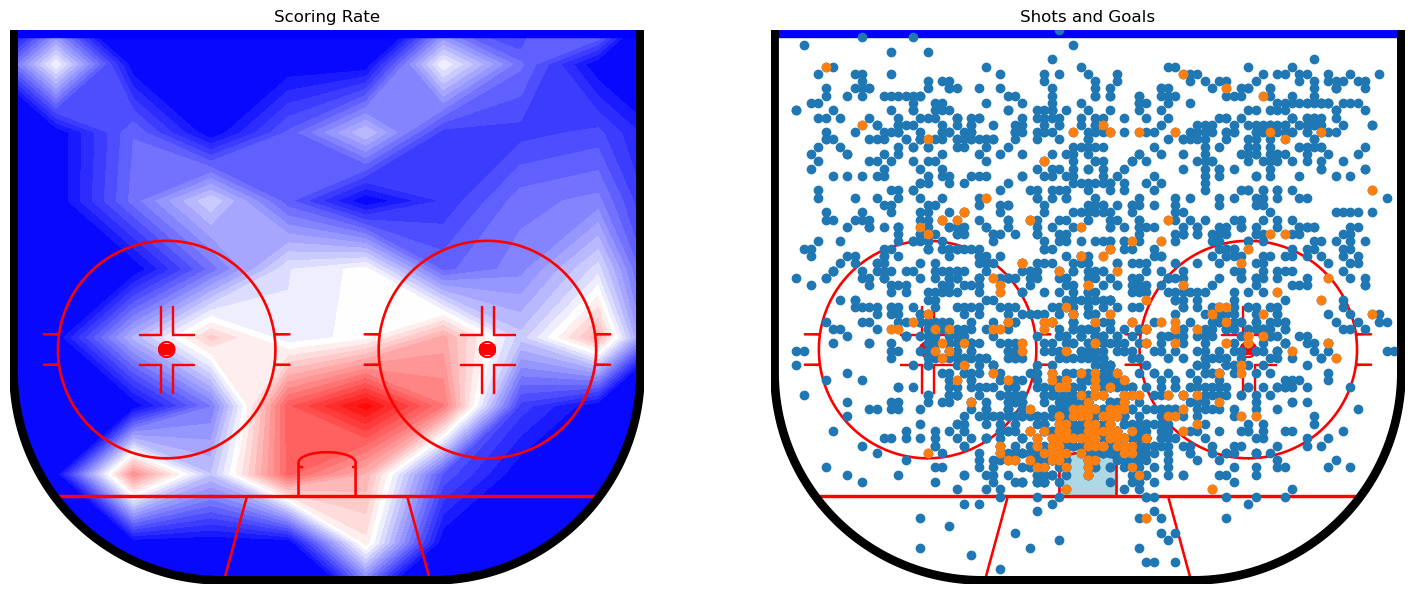

In [57]:
team_analysis("Tampa Bay Lightning",player_complete_stats,shot_probs)